# MLR

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
if not os.path.exists("images"): 
    os.mkdir("images")
pd.set_option('display.max_columns', None)
from scipy.stats import pointbiserialr, f_oneway
from scipy.stats import boxcox

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import Normalizer

Background Info:
 - [Column Definitions](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
 - [Column Variables](https://www.kaggle.com/datasets/ahmedmohameddawoud/ames-housing-data)

Tasks:
 - <a href="#y">Y Variance (Histograms with Transformations)</a><br>
 - <a href="#f_var">Feature Variance (Histograms)</a><br>
 - <a href="#corr">Correlation Matrices</a><br>
 - <a href="#sp_corr">Feature / Salesprice Correlations</a><br>

In [3]:
housing_d = pd.read_csv('housing_cleaned.csv', index_col=0)

In [4]:
housing_d = housing_d.convert_dtypes()
housing_d = housing_d.reset_index().drop(columns = 'PID')
housing_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559 entries, 0 to 2558
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2559 non-null   Int64  
 1   SalePrice      2559 non-null   Int64  
 2   MSSubClass     2559 non-null   Int64  
 3   MSZoning       2559 non-null   string 
 4   LotFrontage    2559 non-null   Int64  
 5   LotArea        2559 non-null   Int64  
 6   Street         2559 non-null   string 
 7   LotShape       2559 non-null   string 
 8   LandContour    2559 non-null   string 
 9   Utilities      2559 non-null   string 
 10  LotConfig      2559 non-null   string 
 11  LandSlope      2559 non-null   string 
 12  Neighborhood   2559 non-null   string 
 13  Condition1     2559 non-null   string 
 14  Condition2     2559 non-null   string 
 15  BldgType       2559 non-null   string 
 16  HouseStyle     2559 non-null   string 
 17  OverallQual    2559 non-null   Int64  
 18  OverallC

In [377]:
continuous = ['SalePrice','GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','YrSold','OverallQual','OverallCond',]
print(len(continuous))
continuous_no_sp = ['GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','YrSold','OverallQual','OverallCond',]


continuous_wlog = ['SalePrice','GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','YrSold','SalesPrice_log','SalePrice_box','OverallQual','OverallCond',]
print(len(continuous_wlog))
categorical = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
              'Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
              'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
              'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir',
              'Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive',
               'PoolQC','Fence','MiscFeature','MoSold','SaleType','SaleCondition']
print(len(categorical))
len(continuous_no_sp)

35
37
43


34

<p><a name="Y"></a></p>

#### Saturated Model, No Feature Engineering

In [53]:
#OneHot Encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')
df = housing_d

# Fit the encoder and transform the 'Category' column
encoded_array = encoder.fit_transform(df[categorical])

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical))
encoded_df #2559x15, automatically drops the first one
df_encoded = pd.concat([df, encoded_df], axis=1)
df_encoded.drop(categorical, axis=1, inplace=True)
df_encoded#.shape #(2559, 301)

,GrLivArea,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MapRefNo,Prop_Addr,lat,long,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_150.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSewr,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_N,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_N,BsmtQual_Po,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_N,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_N,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_N,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_N,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_N,GarageFinish_N,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_N,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_N,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_N,PoolQC_TA,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_N,MiscFeature_N,MiscFeature_Othr,Misc

In [39]:
X = df_encoded.drop(['SalePrice','MapRefNo','Prop_Addr','lat','long'], axis = 1)
y = df_encoded['SalePrice']

In [40]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [41]:
X_train.shape
# X_test
# y_train

(2047, 281)

Trial 1: Normalized with all features

In [346]:
# Define the column transformer Normalized

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Normalizer(), continuous_no_sp),
    ], remainder = 'passthrough')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [347]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred - y_test))
n = X_test.shape[0]
p = X_test.shape[1] - 1  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'R^2: {r2}')
print(f'Adjusted R^2: {adjusted_r2}')
print(f'Mean Squared Error: {mse}')
print("Mean Absolute Error (MAE):", mae)
print(f'Root Mean Squared Error: {rmse}')

R^2: -6.932327601141851e+18
Adjusted R^2: -1.5335148935859247e+19
Mean Squared Error: 4.423232872736397e+28
Mean Absolute Error (MAE): 17227218778739.1
Root Mean Squared Error: 210314832399819.03


Trial 2: Top 10 features

In [351]:
#Extract feature names and coefficients
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame to match feature names with coefficients
coef_df1 = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df1.sort_values(by = 'Coefficient', ascending = False)

,Feature,Coefficient
9,num__TotalBsmtSF,6.096922e+16
15,num__BsmtHalfBath,6.002504e+16
177,remainder__BsmtQual_N,3.220518e+15
216,remainder__KitchenQual_Po,3.138865e+15
51,remainder__MSZoning_I (all),3.051507e+15
...,...,...
192,remainder__BsmtFinType1_N,-3.477060e+15
7,num__BsmtFinSF2,-2.639447e+16
14,num__BsmtHalfBath,-6.002504e+16
8,num__BsmtUnfSF,-6.214834e+16


In [123]:
#Extract feature names and coefficients
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame to match feature names with coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

In [339]:
coef_df

,Feature,Coefficient
34,num__OverallCond,4.231040e+07
33,num__OverallQual,3.277605e+07
21,num__Fireplaces,2.810137e+07
23,num__GarageCars,2.261156e+07
16,num__FullBath,5.259030e+06
...,...,...
17,num__HalfBath,-1.538269e+07
15,num__BsmtHalfBath,-2.312582e+07
14,num__BsmtHalfBath,-2.312582e+07
18,num__BedroomAbvGr,-2.936573e+07


In [144]:
# coef_df['Feature'] = coef_df['Feature'].str.replace(r'num__', '', regex=True).str.replace(r'remainder__', '', regex=True)
trial_2 = coef_df.sort_values(by = 'Coefficient', ascending = False).head(20)
trial_2 = list(trial_2[trial_2.Feature.str.startswith('num')].Feature.str.replace('num__',''))

In [145]:
# Define the column transformer Normalized

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Normalizer(), trial_2),
    ], remainder = 'passthrough')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred - y_test))
n = X_test.shape[0]
p = X_test.shape[1] - 1  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
train_pred = pipeline.predict(X_train)
r2_score(y_train, train_pred)

print(f'R^2 of test set: {r2}')
print(f'Adjusted R^2 of test set: {adjusted_r2}')
print(f'Mean Squared Error: {mse}')
print("Mean Absolute Error (MAE):", mae)
print(f'Root Mean Squared Error: {rmse}')



R^2 of test set: 0.9012145669101066
Adjusted R^2 of test set: 0.7814746480132662
Mean Squared Error: 630309183.48225
Mean Absolute Error (MAE): 16645.341049511553
Root Mean Squared Error: 25105.959122930355


In [356]:
list(coef_df1.sort_values(by = 'Coefficient', ascending = False).head(30).Feature.str.replace(
    'num__','').reset_index().Feature.str.replace('remainder__',''))

['TotalBsmtSF',
 'BsmtHalfBath',
 'BsmtQual_N',
 'KitchenQual_Po',
 'MSZoning_I (all)',
 'BldgType_Duplex',
 'Functional_Sal',
 'GarageFinish_N',
 'BsmtFinType2_N',
 'GarageQual_N',
 'Exterior1st_PreCast',
 'HeatingQC_Po',
 'GrLivArea',
 'GarageCond_Po',
 'GarageCond_TA',
 'GarageCond_Fa',
 'GarageCond_Gd',
 'GarageType_N',
 'RoofMatl_WdShngl',
 'RoofMatl_Membran',
 'Neighborhood_StoneBr',
 'PoolQC_Fa',
 'RoofMatl_Metal',
 'Condition2_PosA',
 'BsmtCond_Po',
 'SaleType_Con',
 'PoolQC_Gd',
 'SaleCondition_Partial',
 'Neighborhood_NoRidge',
 'Exterior1st_BrkFace']

Make a Loop! Loop features 
trial_2

In [360]:
coef_df1.sort_values(by = 'Coefficient', ascending = False).head(20)

,Feature,Coefficient
9,num__TotalBsmtSF,6.096922e+16
15,num__BsmtHalfBath,6.002504e+16
177,remainder__BsmtQual_N,3.220518e+15
216,remainder__KitchenQual_Po,3.138865e+15
51,remainder__MSZoning_I (all),3.051507e+15
110,remainder__BldgType_Duplex,2.763981e+15
222,remainder__Functional_Sal,1.743174e+15
230,remainder__GarageFinish_N,1.704868e+15
198,remainder__BsmtFinType2_N,6.029726e+14
235,remainder__GarageQual_N,4.978146e+14


In [364]:
results = []
# coef_df['Feature'] = coef_df['Feature'].str.replace(r'num__', '', regex=True).str.replace(r'remainder__', '', regex=True)
for i in range(1,50):
    trial = coef_df.sort_values(by = 'Coefficient', ascending = False).head(i)
    trial_num = list(trial[trial.Feature.str.startswith('num')].Feature.str.replace('num__',''))
    trial_fea = list(coef_df.sort_values(by = 'Coefficient', ascending = False).head(i).Feature.str.replace(
    'num__','').reset_index().Feature.str.replace('remainder__',''))
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), trial_num),
        ], remainder = 'passthrough')

    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
        ('regressor', LinearRegression())
        ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train[trial_fea], np.log(y_train))

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test[trial_fea])

    # Evaluate the model
    mse = mean_squared_error(np.log(y_test), y_pred)
    r2 = r2_score(np.log(y_test), y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_pred - np.log(y_test)))
    n = X_test[trial_fea].shape[0]
    p = X_test[trial_fea].shape[1] - 1  # Number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    train_pred = pipeline.predict(X_train[trial_fea])
    r2_score(np.log(y_train), train_pred)
    results.append([r2, adjusted_r2,r2_score(np.log(y_train), train_pred),mse, rmse, mae])

In [367]:
feature_loop# = pd.DataFrame(results, columns = ['r2','adj r2', 'train r2','mse','rmse','mae'])

,r2,adj r2,train r2,mse,rmse,mae
0,-0.003400,-0.003400,0.004796,0.156216,0.395242,0.299447
1,0.655044,0.654368,0.668869,0.053705,0.231744,0.176913
2,0.701866,0.700695,0.706849,0.046416,0.215443,0.166034
3,0.751610,0.750144,0.756599,0.038671,0.196649,0.150333
4,0.779208,0.777466,0.772151,0.034374,0.185404,0.140889
5,0.798297,0.796304,0.791042,0.031403,0.177208,0.137802
6,0.807059,0.804766,0.795422,0.030038,0.173316,0.134959
7,0.844493,0.842333,0.829682,0.024210,0.155597,0.121684
8,0.880602,0.878703,0.868874,0.018589,0.136340,0.101162
9,0.880902,0.878767,0.870565,0.018542,0.136169,0.101063


<Axes: title={'center': 'Adj Test set R2 for MLS of cumulative feaures, 1-50 Log Sales'}>

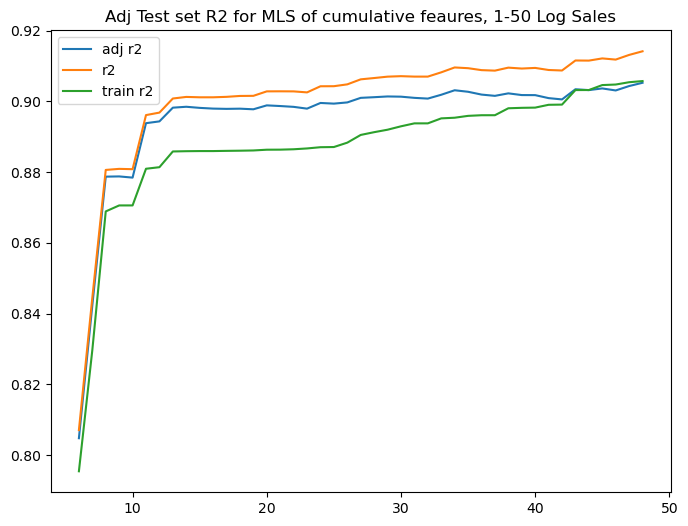

In [366]:
plt.figure(figsize=(8, 6))
feature_loop.drop([0,1,2,3,4,5])['adj r2'].plot.line(title = 'Adj Test set R2 for MLS of cumulative feaures, 1-30 v Log Sales',
                                             legend = True)
feature_loop.drop([0,1,2,3,4,5])['r2'].plot.line(title = 'Adj Test set R2 for MLS of cumulative feaures, 1-30 v Log Sales', 
                                         legend = True)
feature_loop.drop([0,1,2,3,4,5])['train r2'].plot.line(title = 'Adj Test set R2 for MLS of cumulative feaures, 1-50 Log Sales', 
                                               legend = True
                                            )
# plt.savefig('images/MLS_LogY_R2_cum30.png')

In [369]:
feature_loop

,r2,adj r2,train r2,mse,rmse,mae
0,-0.003400,-0.003400,0.004796,0.156216,0.395242,0.299447
1,0.655044,0.654368,0.668869,0.053705,0.231744,0.176913
2,0.701866,0.700695,0.706849,0.046416,0.215443,0.166034
3,0.751610,0.750144,0.756599,0.038671,0.196649,0.150333
4,0.779208,0.777466,0.772151,0.034374,0.185404,0.140889
5,0.798297,0.796304,0.791042,0.031403,0.177208,0.137802
6,0.807059,0.804766,0.795422,0.030038,0.173316,0.134959
7,0.844493,0.842333,0.829682,0.024210,0.155597,0.121684
8,0.880602,0.878703,0.868874,0.018589,0.136340,0.101162
9,0.880902,0.878767,0.870565,0.018542,0.136169,0.101063


In [372]:
list(coef_df.sort_values(by = 'Coefficient', ascending = False).head(12).Feature.str.replace('num__',''))

['OverallCond',
 'OverallQual',
 'Fireplaces',
 'GarageCars',
 'FullBath',
 'YearBuilt',
 'LotFrontage',
 '1stFlrSF',
 'GrLivArea',
 'ScreenPorch',
 'MasVnrArea',
 'BsmtFinSF1']

Highest adjusted r squared for this line fo inquiry - MLS, selection by coefficients. 
['OverallCond',
 'OverallQual',
 'Fireplaces',
 'GarageCars',
 'FullBath',
 'YearBuilt',
 'LotFrontage']. All are continuous, which asks whether I have explored the categorical enough. 

Text(0.5, 1.0, 'Top 12 feature correlation matrix')

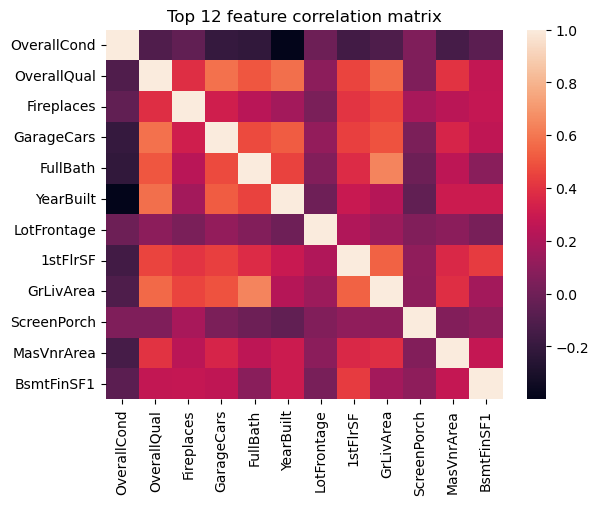

In [374]:
sns.heatmap(housing_d[list(coef_df.sort_values(by = 'Coefficient', ascending = False).head(12).Feature.str.replace('num__',''))].corr())
plt.title('Top 12 feature correlation matrix')

In [245]:
coef_df = coef_df.sort_values(by = 'Coefficient', ascending = False)
coef_df_rank = coef_df.reset_index().drop('index', axis= 1)
coef_df_rank[coef_df_rank.Feature == 'num__YearRemodAdd']

,Feature,Coefficient
272,num__YearRemodAdd,-267956.859758


In [333]:
def quick_mls (cont, cat=[], log = 'No'):
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), cont),
        ], remainder = 'passthrough')

    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
        ('regressor', LinearRegression())
        ])

    # Fit the pipeline on the training data
    if log == 'Yes':
        pipeline.fit(X_train[cont+cat], np.log(y_train))

        # Make predictions on the test data
        y_pred = pipeline.predict(X_test[cont+cat])

        # Evaluate the model
        mse = mean_squared_error(np.log(y_test), y_pred)
        r2 = r2_score(np.log(y_test), y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_pred - np.log(y_test)))
        n = X_test[cont+cat].shape[0]
        p = X_test[cont+cat].shape[1] - 1  # Number of predictors
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        train_pred = pipeline.predict(X_train)
        #r2_score(np.log(y_train), train_pred)
    else:
        
        pipeline.fit(X_train[cont+cat], y_train)

        # Make predictions on the test data
        y_pred = pipeline.predict(X_test[cont+cat])

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_pred - y_test))
        n = X_test[cont+cat].shape[0]
        p = X_test[cont+cat].shape[1] - 1  # Number of predictors
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        train_pred = pipeline.predict(X_train)
        #r2_score(np.log(y_train), train_pred)
        
    print(f'R^2 of test set: {r2}')
    print(f'Adjusted R^2 of test set: {adjusted_r2}')
    print(f'Mean Squared Error: {mse}')
    print("Mean Absolute Error (MAE):", mae)
    print(f'Root Mean Squared Error: {rmse}')

In [375]:
quick_mls(['OverallCond',
 'OverallQual',
 'Fireplaces',
 'GarageCars',
 'FullBath',
 'YearBuilt',
 'LotFrontage',
 '1stFlrSF',
 'GrLivArea',
 'ScreenPorch',
 'MasVnrArea',
 'BsmtFinSF1'],log = 'Yes')

R^2 of test set: 0.8758970511356539
Adjusted R^2 of test set: 0.8731667862606383
Mean Squared Error: 0.01932121270785855
Mean Absolute Error (MAE): 0.10277755856421844
Root Mean Squared Error: 0.13900076513407597


#### Lasso